# Imports

In [6]:
import numpy as np
import pandas as pd
import builtins
import pyfolio as pf
# from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
#                      INFO, WARNING, DEBUG, ERROR)
from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, symbol
# import pyfolio as pf
# from pyfolio.utils import extract_rets_pos_txn_from_zipline
import matplotlib.pyplot as plt
import seaborn as sns

# Performance Functions

In [7]:
def rolling_sharpe(ret):
    return np.multiply(np.divide(ret.mean(), ret.std()), np.sqrt(252))

def get_rolling_stats(result, r_window):
    result["rolling_sharpe"] = result["portfolio_value"].pct_change().rolling(r_window).apply(rolling_sharpe)
    result["rolling_vol"] = result["portfolio_value"].pct_change().rolling(r_window).std()
    stats = [result.rolling_sharpe.mean(), result.portfolio_value.mean(), result.rolling_vol.mean()]
    return result, stats

def show_rolling_stats(result, r_window):
    result, stats = get_rolling_stats(result, r_window)
    fig, ax = plt.subplots(1, 3, figsize=(18,4))
    result['rolling_sharpe'].plot(ax = ax[0], title='Rolling sharpe')
    result['rolling_vol'].plot(ax = ax[1], title='Rolling vol')
    result['portfolio_value'].plot(ax = ax[2], title='Portfolio value')
    plt.show()
    return result

# Check Bundels

In [3]:
!zipline bundles

csvdir <no ingestions>
multi_asset_snp100 2023-12-15 21:32:50.035515
multi_asset_snp100 2023-12-15 21:28:12.594941
multi_asset_snp100 2023-12-15 21:24:39.564635
multi_asset_snp100 2023-12-15 07:44:01.699372
multi_asset_snp100 2023-12-15 07:41:38.488699
multi_asset_snp100 2023-12-15 07:32:05.248661
multi_asset_snp100 2023-12-15 07:29:10.693330
multi_asset_snp100 2023-12-15 07:23:30.053949
quandl 2023-12-12 14:51:06.970977
quandl 2023-12-11 18:58:51.384085
quandl 2023-12-11 18:58:18.790981
quandl 2023-12-11 17:27:05.201175
quandl 2023-12-11 17:16:04.140642
quandl 2023-12-11 09:19:57.807125
quandl 2023-12-11 09:18:50.209032
quandl 2023-12-11 09:14:10.865540
quandl 2023-12-11 06:27:30.829838
quandl 2023-12-10 12:31:04.001536
quandl 2023-12-10 12:22:46.640028
quantopian-quandl <no ingestions>
sp100_bundle 2023-12-15 10:12:49.964266
sp100_bundle 2023-12-12 14:30:55.178197


In [8]:
!zipline ingest -b multi_asset_snp100

[2023-12-18T13:33:07+0600-INFO][zipline.data.bundles.core]
 Ingesting multi_asset_snp100
Loading custom pricing data:   [####################################]  100%
Merging daily equity files:  [####################################]     
[2023-12-18T13:33:08+0600-INFO][root]
 creating /home/subrina/.zipline/data/multi_asset_snp100/2023-12-18T07;33;07.167537/daily_equities.bcolz
[2023-12-18T13:33:08+0600-INFO][root]
 copying /tmp/tmp0gqssf6c/multi_asset_snp100/2023-12-18T07;33;07.167537/daily_equities.bcolz/__attrs__ -> /home/subrina/.zipline/data/multi_asset_snp100/2023-12-18T07;33;07.167537/daily_equities.bcolz
[2023-12-18T13:33:08+0600-INFO][root]
 creating /home/subrina/.zipline/data/multi_asset_snp100/2023-12-18T07;33;07.167537/daily_equities.bcolz/close
[2023-12-18T13:33:08+0600-INFO][root]
 copying /tmp/tmp0gqssf6c/multi_asset_snp100/2023-12-18T07;33;07.167537/daily_equities.bcolz/close/__attrs__ -> /home/subrina/.zipline/data/multi_asset_snp100/2023-12-18T07;33;07.167537/daily_e

In [5]:
!zipline bundles

csvdir <no ingestions>
multi_asset_snp100 2023-12-15 21:54:57.685235
multi_asset_snp100 2023-12-15 21:32:50.035515
multi_asset_snp100 2023-12-15 21:28:12.594941
multi_asset_snp100 2023-12-15 21:24:39.564635
multi_asset_snp100 2023-12-15 07:44:01.699372
multi_asset_snp100 2023-12-15 07:41:38.488699
multi_asset_snp100 2023-12-15 07:32:05.248661
multi_asset_snp100 2023-12-15 07:29:10.693330
multi_asset_snp100 2023-12-15 07:23:30.053949
quandl 2023-12-12 14:51:06.970977
quandl 2023-12-11 18:58:51.384085
quandl 2023-12-11 18:58:18.790981
quandl 2023-12-11 17:27:05.201175
quandl 2023-12-11 17:16:04.140642
quandl 2023-12-11 09:19:57.807125
quandl 2023-12-11 09:18:50.209032
quandl 2023-12-11 09:14:10.865540
quandl 2023-12-11 06:27:30.829838
quandl 2023-12-10 12:31:04.001536
quandl 2023-12-10 12:22:46.640028
quantopian-quandl <no ingestions>
sp100_bundle 2023-12-15 10:12:49.964266
sp100_bundle 2023-12-12 14:30:55.178197


# Initialize Variables

In [9]:
# Set the start and end dates
start_date = pd.Timestamp('2011-01-01')
end_date = pd.Timestamp('2020-01-01')
capital_base = 10_000
# calendar = get_calendar('XDSE')
symb = 'AAPL'
bollinger_window = 30
bollinger_dev = 2

# ZipLine Functions

In [10]:
def initialize(context):
    context.i = 0
    context.asset = symbol(symb)
    context.bollinger_window = bollinger_window  # Bollinger Bands window
    context.bollinger_dev = bollinger_dev  # Number of standard deviations for Bollinger Bands

def handle_data(context, data):
    context.i += 1
    if context.i < context.bollinger_window:
        return
    buy_signal = False
    sell_signal = False
    # Get historical price data
    prices = data.history(context.asset, 'close', context.bollinger_window + 1, frequency='1d')
    # print(prices)
    # Calculate Bollinger Bands
    sma = prices.mean()
    rolling_std = prices.std()
    upper_band = sma + (context.bollinger_dev * rolling_std)
    lower_band = sma - (context.bollinger_dev * rolling_std)

    # Get the current price
    current_price = data.current(context.asset, 'close')

    # Generate signals based on Bollinger Bands
    if current_price > upper_band:
        order_target_percent(context.asset, -0.5)  # Short position
        buy_signal=True
    elif current_price < lower_band:
        order_target_percent(context.asset, 0.5)  # Long position
        sell_signal=True
    else:
        order_target_percent(context.asset, 0)  # Close position

    # Record the values for later analysis
    record(price=current_price, upper=upper_band, lower=lower_band)
    record(
        AAPL=current_price,
        lower_band=lower_band, upper_band=upper_band,
        sell_signal = sell_signal,
        buy_signal = buy_signal,
        price_hist=prices
    )

In [11]:
# Run the algorithm
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)

/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


# Volitility, Sharpe Ratio and Portfolio Value Chart

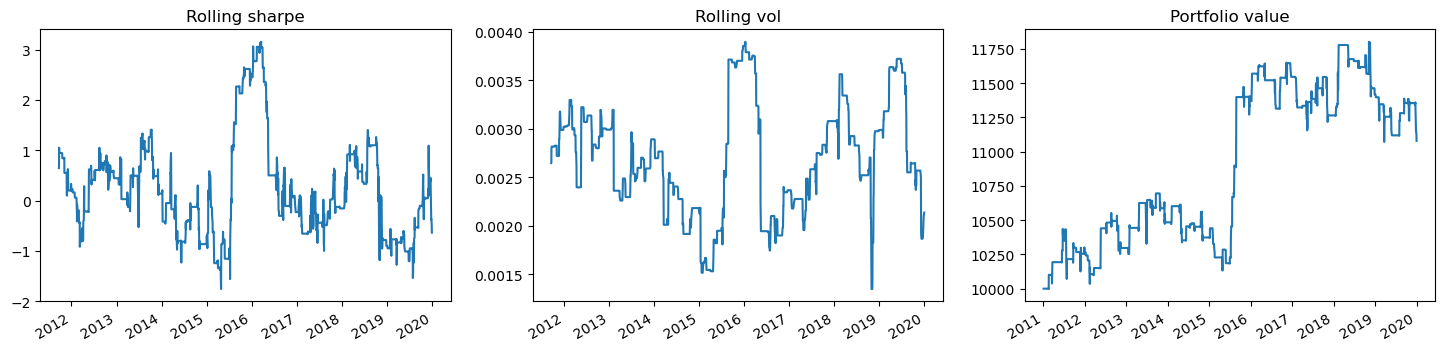

In [9]:
result = show_rolling_stats(result, 180)

In [10]:
#dir(result)

# Tear Sheet

In [11]:
# returns = result['returns']
# pf.create_returns_tear_sheet(returns)

# Variable Initiallization for Multi Assets

In [14]:
bundle = 'multi_asset_snp100'
bundle_data = bundles.load(bundle)
sids = bundle_data.asset_finder.sids
assets = bundle_data.asset_finder.retrieve_all(sids)
# Set the start and end dates
start_date = pd.Timestamp('2011-01-01')
end_date = pd.Timestamp('2020-01-01')
capital_base = 10_000
# calendar = get_calendar('XDSE')


In [13]:
print(assets)

[Equity(0 [AAPL]), Equity(1 [ABBV]), Equity(2 [ABT]), Equity(3 [ACN]), Equity(4 [ADBE]), Equity(5 [AIG]), Equity(6 [AMD]), Equity(7 [AMGN]), Equity(8 [AMT]), Equity(9 [AMZN]), Equity(10 [AVGO]), Equity(11 [AXP]), Equity(12 [BA]), Equity(13 [BAC]), Equity(14 [BK]), Equity(15 [BKNG]), Equity(16 [BLK]), Equity(17 [BMY]), Equity(18 [BRK-B]), Equity(19 [C]), Equity(20 [CAT]), Equity(21 [CHTR]), Equity(22 [CL]), Equity(23 [CMCSA]), Equity(24 [COF]), Equity(25 [COP]), Equity(26 [COST]), Equity(27 [CRM]), Equity(28 [CSCO]), Equity(29 [CVS]), Equity(30 [CVX]), Equity(31 [DE]), Equity(32 [DHR]), Equity(33 [DIS]), Equity(34 [DOW]), Equity(35 [DUK]), Equity(36 [EMR]), Equity(37 [EXC]), Equity(38 [F]), Equity(39 [FDX]), Equity(40 [GD]), Equity(41 [GE]), Equity(42 [GILD]), Equity(43 [GM]), Equity(44 [GOOG]), Equity(45 [GOOGL]), Equity(46 [GS]), Equity(47 [HD]), Equity(48 [HON]), Equity(49 [IBM]), Equity(50 [INTC]), Equity(51 [JNJ]), Equity(52 [JPM]), Equity(53 [KHC]), Equity(54 [KO]), Equity(55 [LIN

# Zipline Functions

In [7]:
def initialize(context):
    context.i = 0
    set_benchmark(symbol(symb))
    sids = bundle_data.asset_finder.sids
    context.assets = bundle_data.asset_finder.retrieve_all(sids)
    context.bollinger_window = bollinger_window  # Bollinger Bands window
    context.bollinger_dev = bollinger_dev  # Number of standard deviations for Bollinger Bands
    context.stop_loss_percent = stop_loss_percent

def exec_trade(data, positions):
    for asset, target_percent in positions.items():
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

def handle_data(context, data):
    buy_signal = False
    sell_signal = False
    for asset in context.assets:
        # Get historical price data
        prices = data.history(asset, 'close', context.bollinger_window + 1, frequency='1d')
        # print(prices)
        # Calculate Bollinger Bands
        sma = prices.mean()
        rolling_std = prices.std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)
    
        # Get the current price
        current_price = data.current(asset, 'close')
    
        open_orders = get_open_orders()
        # Check if the asset is still tradable
        if data.can_trade(asset):
            # Generate signals based on Bollinger Bands
            if current_price > upper_band:
                order_target_percent(asset, -0.5)  # Short position
                sell_signal=True
            elif current_price < lower_band:
                order_target_percent(asset, 0.5)  # Long position
                buy_signal=True
            else:
                order_target_percent(asset, 0)  # Close position
        
        # Record the values for later analysis
        record(price=current_price, upper=upper_band, lower=lower_band)
        record(
            AAPL=current_price,
            lower_band=lower_band, upper_band=upper_band,
            sell_signal = sell_signal,
            buy_signal = buy_signal,
            price_hist=prices
        )

In [8]:
# Run the algorithm
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)

NameError: name 'start_date' is not defined

In [16]:
result.returns

2020-01-02 21:00:00+00:00    0.000000
2020-01-03 21:00:00+00:00   -0.004973
2020-01-06 21:00:00+00:00   -0.032565
2020-01-07 21:00:00+00:00   -0.008394
2020-01-08 21:00:00+00:00   -0.017883
                               ...   
2021-07-26 20:00:00+00:00   -0.004006
2021-07-27 20:00:00+00:00    0.021878
2021-07-28 20:00:00+00:00    0.025509
2021-07-29 20:00:00+00:00   -0.008626
2021-07-30 20:00:00+00:00    0.003175
Name: returns, Length: 398, dtype: float64

# Volitility, Sharpe Ratio and Portfolio Value

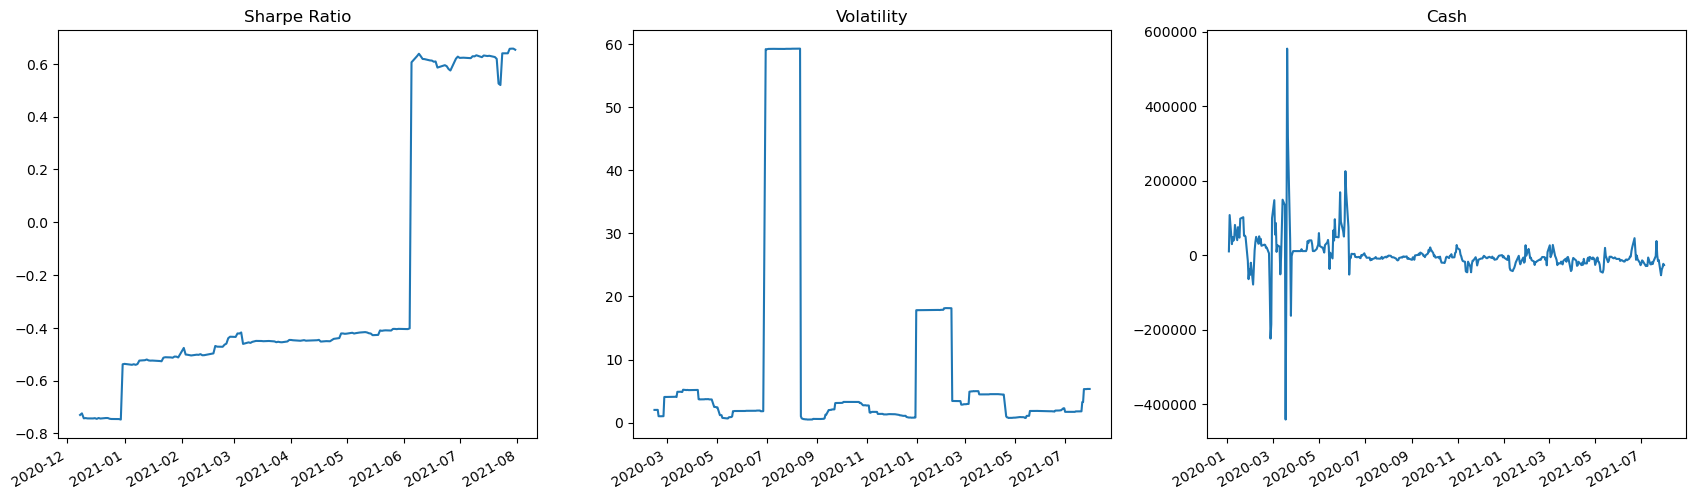

In [15]:
result["vols"] = result.starting_cash.pct_change().rolling(30).std()
def my_rolling_sharpe(ser):
    return np.sqrt(90) * (ser.mean()/ser.std())
result["sharpe_ratio"] = result['starting_cash'].pct_change().rolling(235).apply(my_rolling_sharpe)
fig, ax = plt.subplots(1, 3, figsize=(21,6))
result['sharpe_ratio'].plot(ax = ax[0], title='Sharpe Ratio')
result['vols'].plot(ax = ax[1], title='Volatility')
result['ending_cash'].plot(ax = ax[2], title='Cash')
plt.show()

In [1]:
pf.create_returns_tear_sheet(returns=result.algorithm_period_return, benchmark_rets=None)

NameError: name 'pf' is not defined

## Stop Loss

In [17]:
# A stop price is used in conjunction with a stop order to trigger a market order when the asset's price reaches or surpasses a certain level.
# For a sell stop order, the stop price is the price at which the market order is triggered. Once the stop price is reached, the order becomes a market sell order.
# For a buy stop order, the stop price is the price at which the market order is triggered. Once the stop price is reached, the order becomes a market buy order.
def initialize(context):
    context.i = 0
    set_benchmark(symbol(symb))
    sids = bundle_data.asset_finder.sids
    context.assets = bundle_data.asset_finder.retrieve_all(sids)
    context.bollinger_window = 20  # Bollinger Bands window
    context.bollinger_dev = 1  # Number of standard deviations for Bollinger Bands
    context.stop_loss_percent = 0.1
def handle_data(context, data):
    buy_signal = False
    sell_signal = False
    for asset in context.assets:
        prices = data.history(asset, 'close', context.bollinger_window + 1, frequency='1d')
        # Calculate Bollinger Bands
        sma = prices.mean()
        rolling_std = prices.std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)
    
        # Get the current price
        current_price = data.current(asset, 'close')
    
        open_orders = get_open_orders()
        # Check if the asset is still tradable
        if data.can_trade(asset):
            cash = context.portfolio.cash

            if current_price > upper_band:
                limit_price = current_price * (1 - context.take_profit_percent)
                order_target(asset, -(cash // current_price), limit_price=limit_price)  # Short position
            # Generate signals based on Bollinger Bands
            if current_price > upper_band:
                order_target_percent(asset, -0.5,stop_price=current_price * (1 - context.stop_loss_percent))  # Short position
                sell_signal = True
            elif current_price < lower_band:
                order_target_percent(asset, 0.5,stop_price=current_price * (1 + context.stop_loss_percent) )  # Long position
                buy_signal = True
            else:
                order_target_percent(asset, 0)  # Close position

        # Record the values for later analysis
        record(price=current_price, upper=upper_band, lower=lower_band)
        record(
            AAPL=current_price,
            lower_band=lower_band, upper_band=upper_band,
            sell_signal=sell_signal,
            buy_signal=buy_signal,
            price_hist=prices
        )


In [18]:
# Run the algorithm
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)

/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/data/data_portal.py:951: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


In [ ]:
result.returns

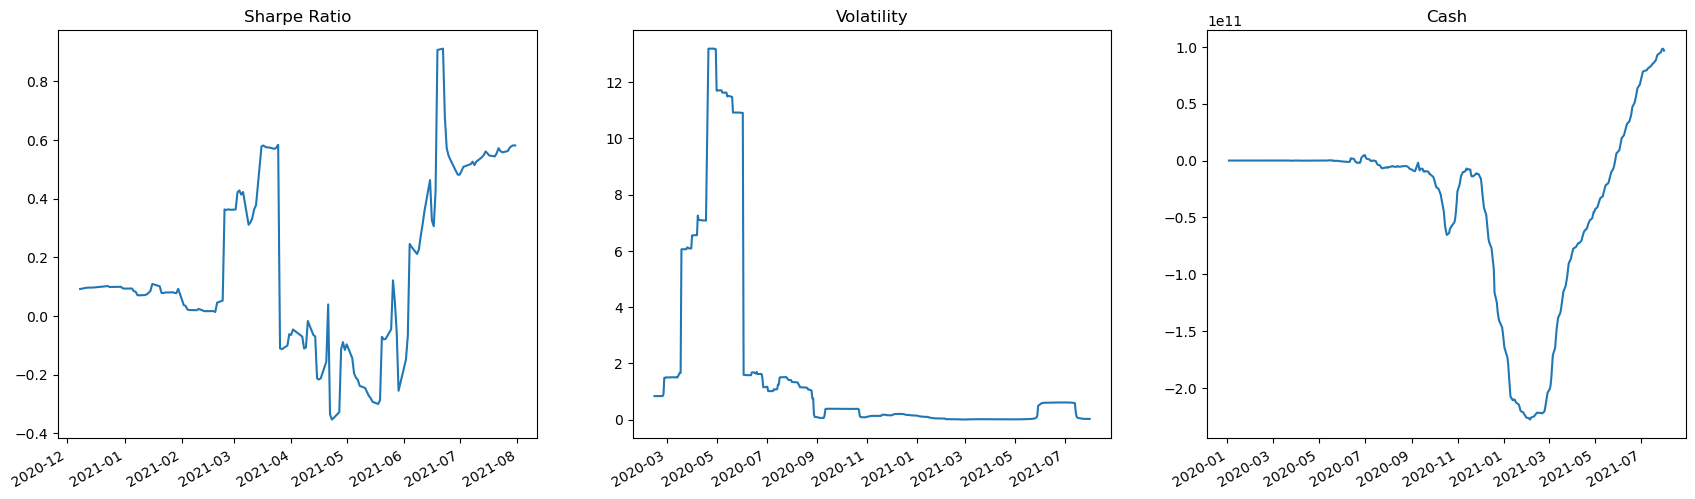

In [19]:
result["vols"] = result.starting_cash.pct_change().rolling(30).std()
def my_rolling_sharpe(ser):
    return np.sqrt(90) * (ser.mean()/ser.std())
result["sharpe_ratio"] = result['starting_cash'].pct_change().rolling(235).apply(my_rolling_sharpe)
fig, ax = plt.subplots(1, 3, figsize=(21,6))
result['sharpe_ratio'].plot(ax = ax[0], title='Sharpe Ratio')
result['vols'].plot(ax = ax[1], title='Volatility')
result['ending_cash'].plot(ax = ax[2], title='Cash')
plt.show()

/home/subrina/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/subrina/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:158: RuntimeWarning: overflow encountered in accumulate
  out.cumprod(axis=0, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:293: RuntimeWarning: invalid value encountered in subtract
  np.divide((out - max_return), max_return, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:293: RuntimeWarning: invalid value encountered in divide
  np.divide((out - max_return), max_return, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning

/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:158: RuntimeWarning: overflow encountered in accumulate
  out.cumprod(axis=0, out=out)


/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:158: RuntimeWarning: overflow encountered in accumulate
  out.cumprod(axis=0, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:158: RuntimeWarning: overflow encountered in accumulate
  out.cumprod(axis=0, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:158: RuntimeWarning: overflow encountered in accumulate
  out.cumprod(axis=0, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:158: RuntimeWarning: overflow encountered in accumulate
  out.cumprod(axis=0, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:158: RuntimeWarning: overflow encountered in accumulate
  out.cumprod(axis=0, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packa

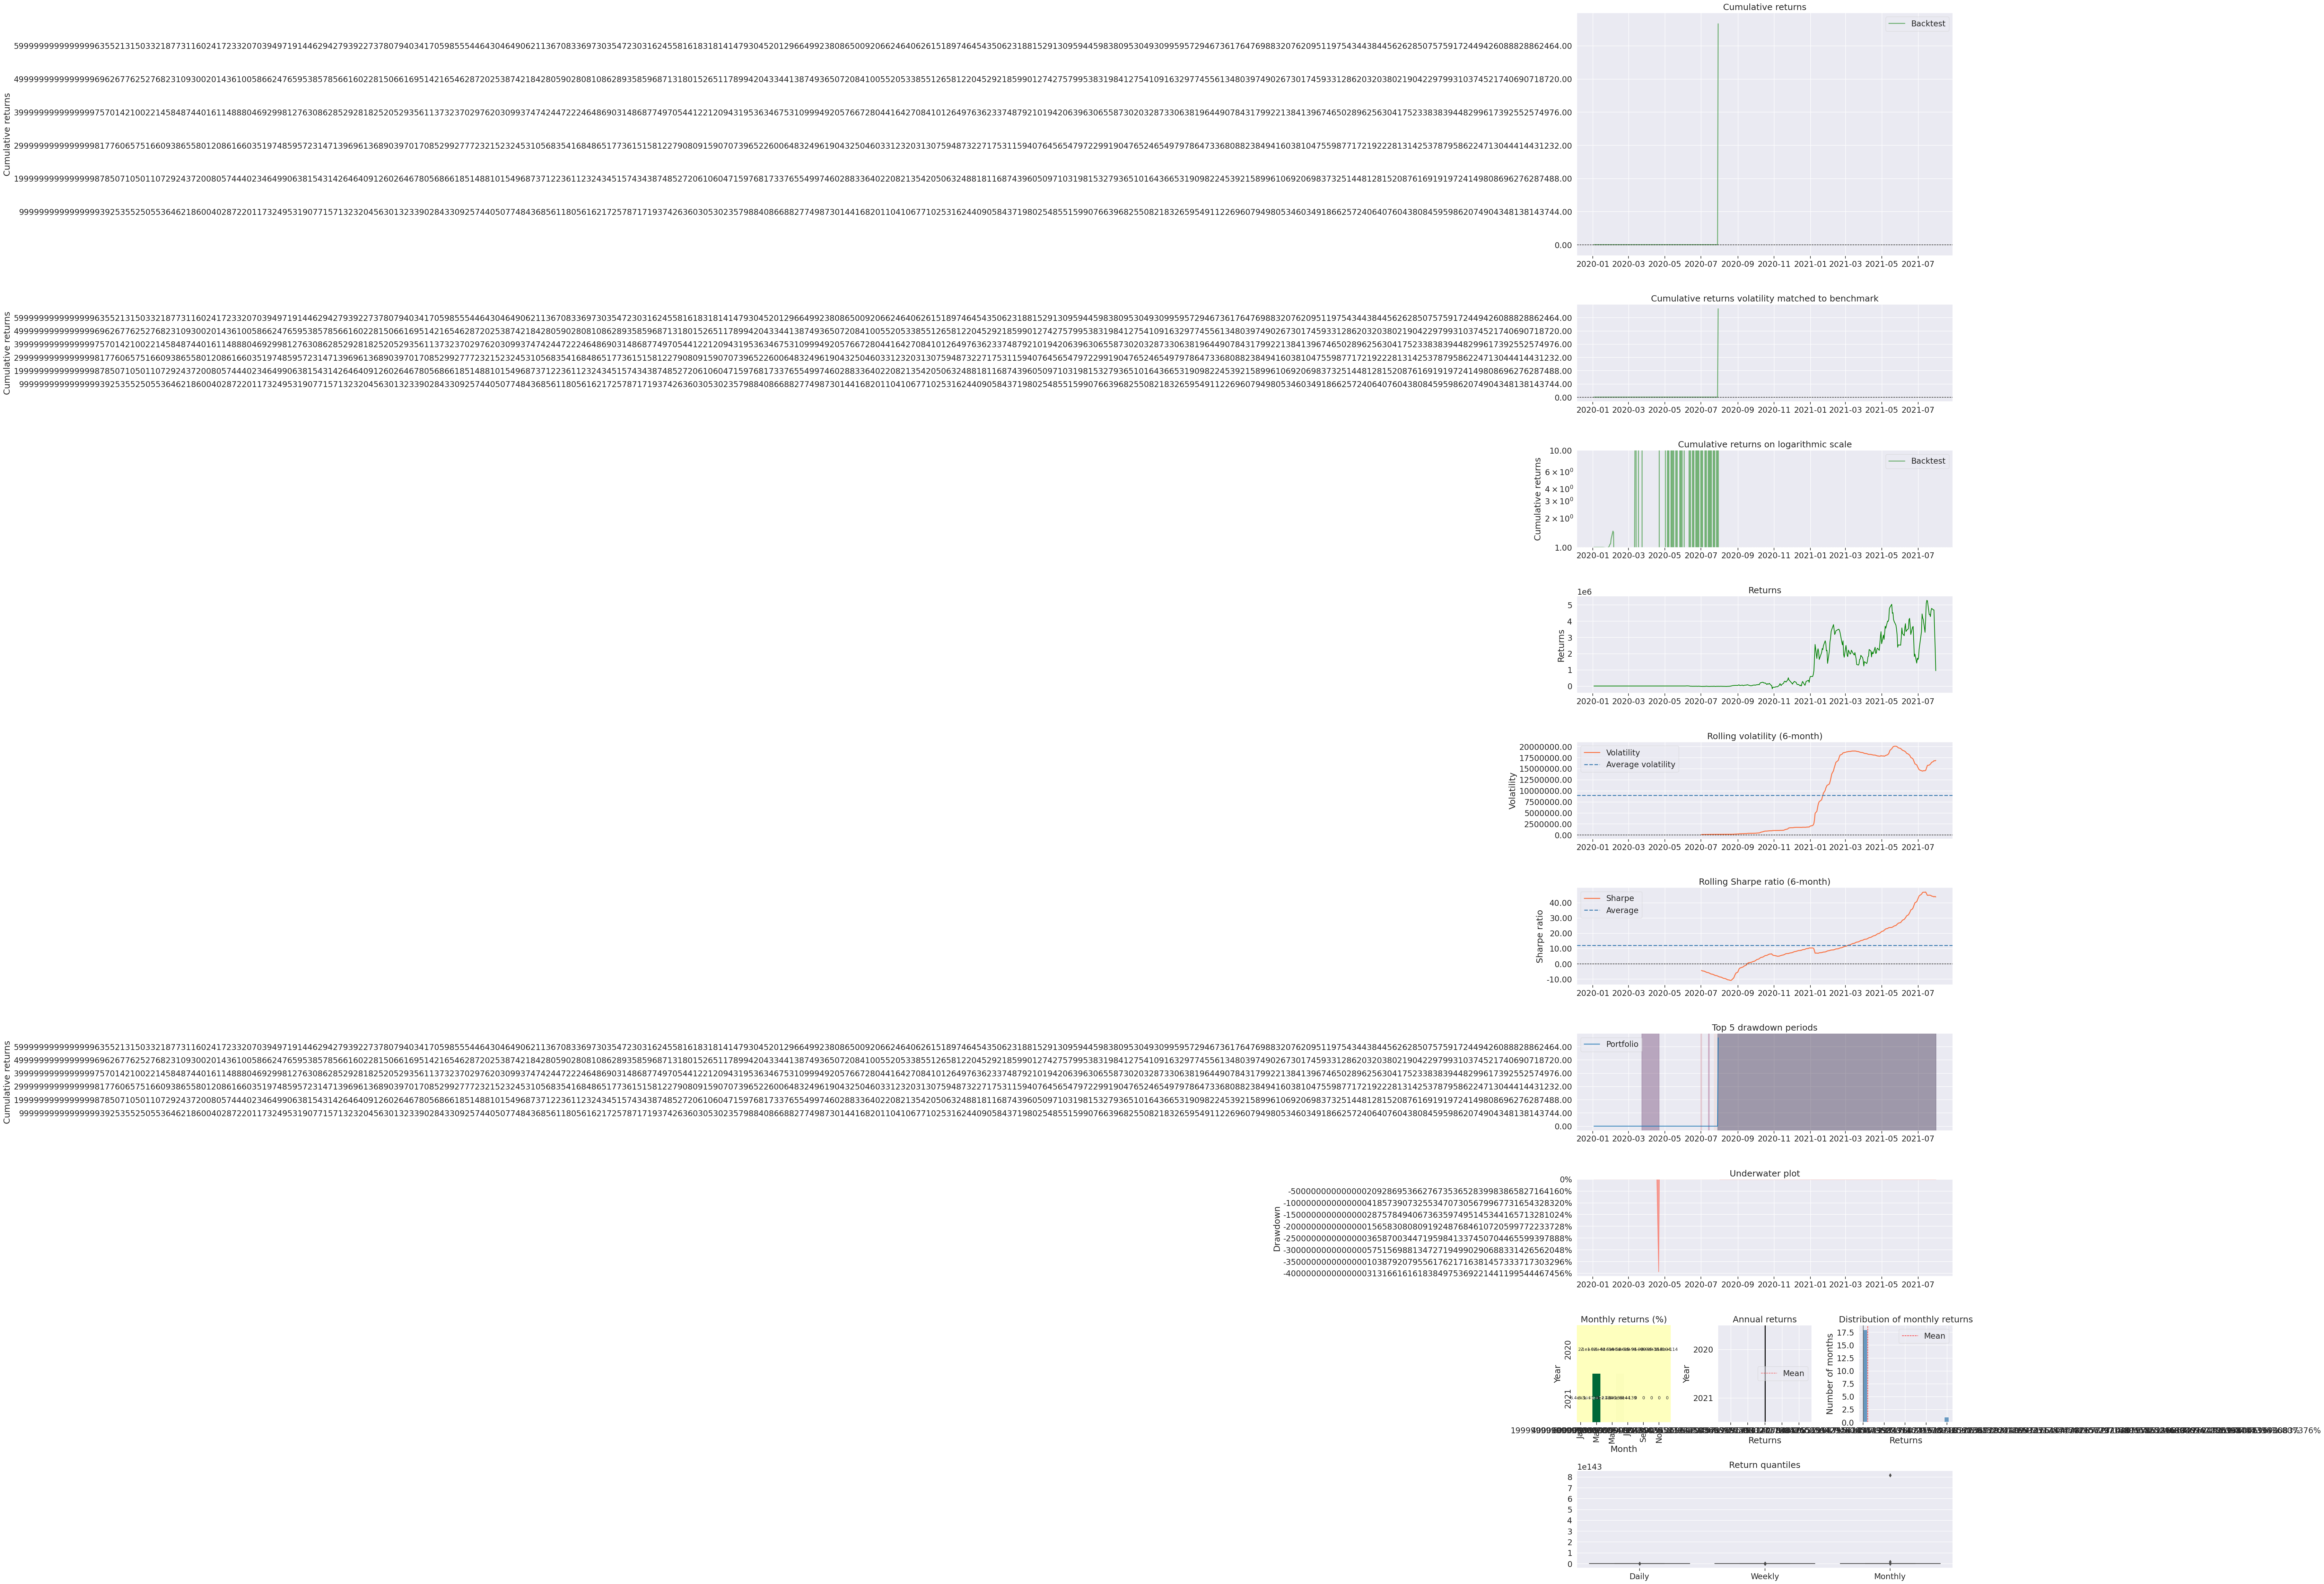

In [20]:
pf.create_returns_tear_sheet(returns=result.algorithm_period_return, benchmark_rets=None)

## Take Profit

In [14]:
#A limit price is the specific price at which a trader wants to buy or sell an asset.
# For a buy order, the limit price is the maximum price the trader is willing to pay.
# For a sell order, the limit price is the minimum price the trader is willing to accept.
# The order will only be executed at the specified limit price or better.
take_profit_percent=0.1
def initialize(context):
    context.i = 0
    set_benchmark(symbol(symb))
    sids = bundle_data.asset_finder.sids
    context.assets = bundle_data.asset_finder.retrieve_all(sids)
    context.bollinger_window = bollinger_window  # Bollinger Bands window
    context.bollinger_dev = bollinger_dev  # Number of standard deviations for Bollinger Bands
    context.take_profit_percent = take_profit_percent  # Define Take Profit percentage

def handle_data(context, data):
    buy_signal = False
    sell_signal = False
    take_profit_executed = False
    for asset in context.assets:
        # Get historical price data
        prices = data.history(asset, 'close', context.bollinger_window + 1, frequency='1d')

        # Calculate Bollinger Bands
        sma = prices.mean()
        rolling_std = prices.std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        # Get current price and open orders
        current_price = data.current(asset, 'close')
        open_orders = get_open_orders()

        # Check if asset is tradable
        if data.can_trade(asset):
            cash = context.portfolio.cash

            if current_price > upper_band:
                limit_price = current_price * (1 - context.take_profit_percent)
                order_target(asset, -(cash // current_price), limit_price=limit_price)  # Short position
            elif current_price < lower_band:
                limit_price = current_price * (1 + context.take_profit_percent)
                order_target(asset, cash // current_price, limit_price=limit_price)  

        # Record data for analysis
        record(price=current_price, upper=upper_band, lower=lower_band)
        record(
            AAPL=current_price,
            lower_band=lower_band, upper_band=upper_band,
            sell_signal=sell_signal,
            buy_signal=buy_signal,
            price_hist=prices,
            take_profit=take_profit_executed,
        )



In [15]:
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)

/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/data/data_portal.py:951: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


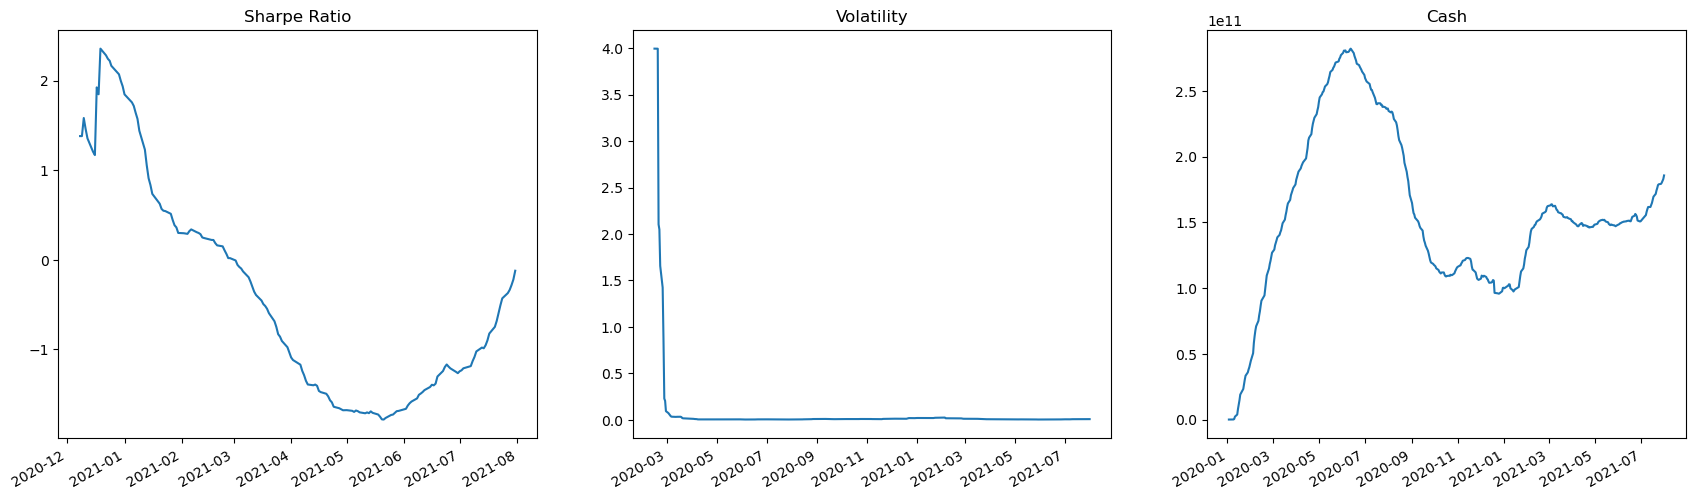

In [16]:
result["vols"] = result.starting_cash.pct_change().rolling(30).std()
def my_rolling_sharpe(ser):
    return np.sqrt(90) * (ser.mean()/ser.std())
result["sharpe_ratio"] = result['starting_cash'].pct_change().rolling(235).apply(my_rolling_sharpe)
fig, ax = plt.subplots(1, 3, figsize=(21,6))
result['sharpe_ratio'].plot(ax = ax[0], title='Sharpe Ratio')
result['vols'].plot(ax = ax[1], title='Volatility')
result['ending_cash'].plot(ax = ax[2], title='Cash')
plt.show()

/home/subrina/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/subrina/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:158: RuntimeWarning: overflow encountered in accumulate
  out.cumprod(axis=0, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:163: RuntimeWarning: overflow encountered in multiply
  np.multiply(out, starting_value, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:293: RuntimeWarning: invalid value encountered in subtract
  np.divide((out - max_return), max_return, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:293: RuntimeWarning: invalid value en

/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:158: RuntimeWarning: overflow encountered in accumulate
  out.cumprod(axis=0, out=out)


/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:158: RuntimeWarning: overflow encountered in accumulate
  out.cumprod(axis=0, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:158: RuntimeWarning: overflow encountered in accumulate
  out.cumprod(axis=0, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:158: RuntimeWarning: overflow encountered in accumulate
  out.cumprod(axis=0, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:158: RuntimeWarning: overflow encountered in accumulate
  out.cumprod(axis=0, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:158: RuntimeWarning: overflow encountered in accumulate
  out.cumprod(axis=0, out=out)
/home/subrina/anaconda3/lib/python3.11/site-packa

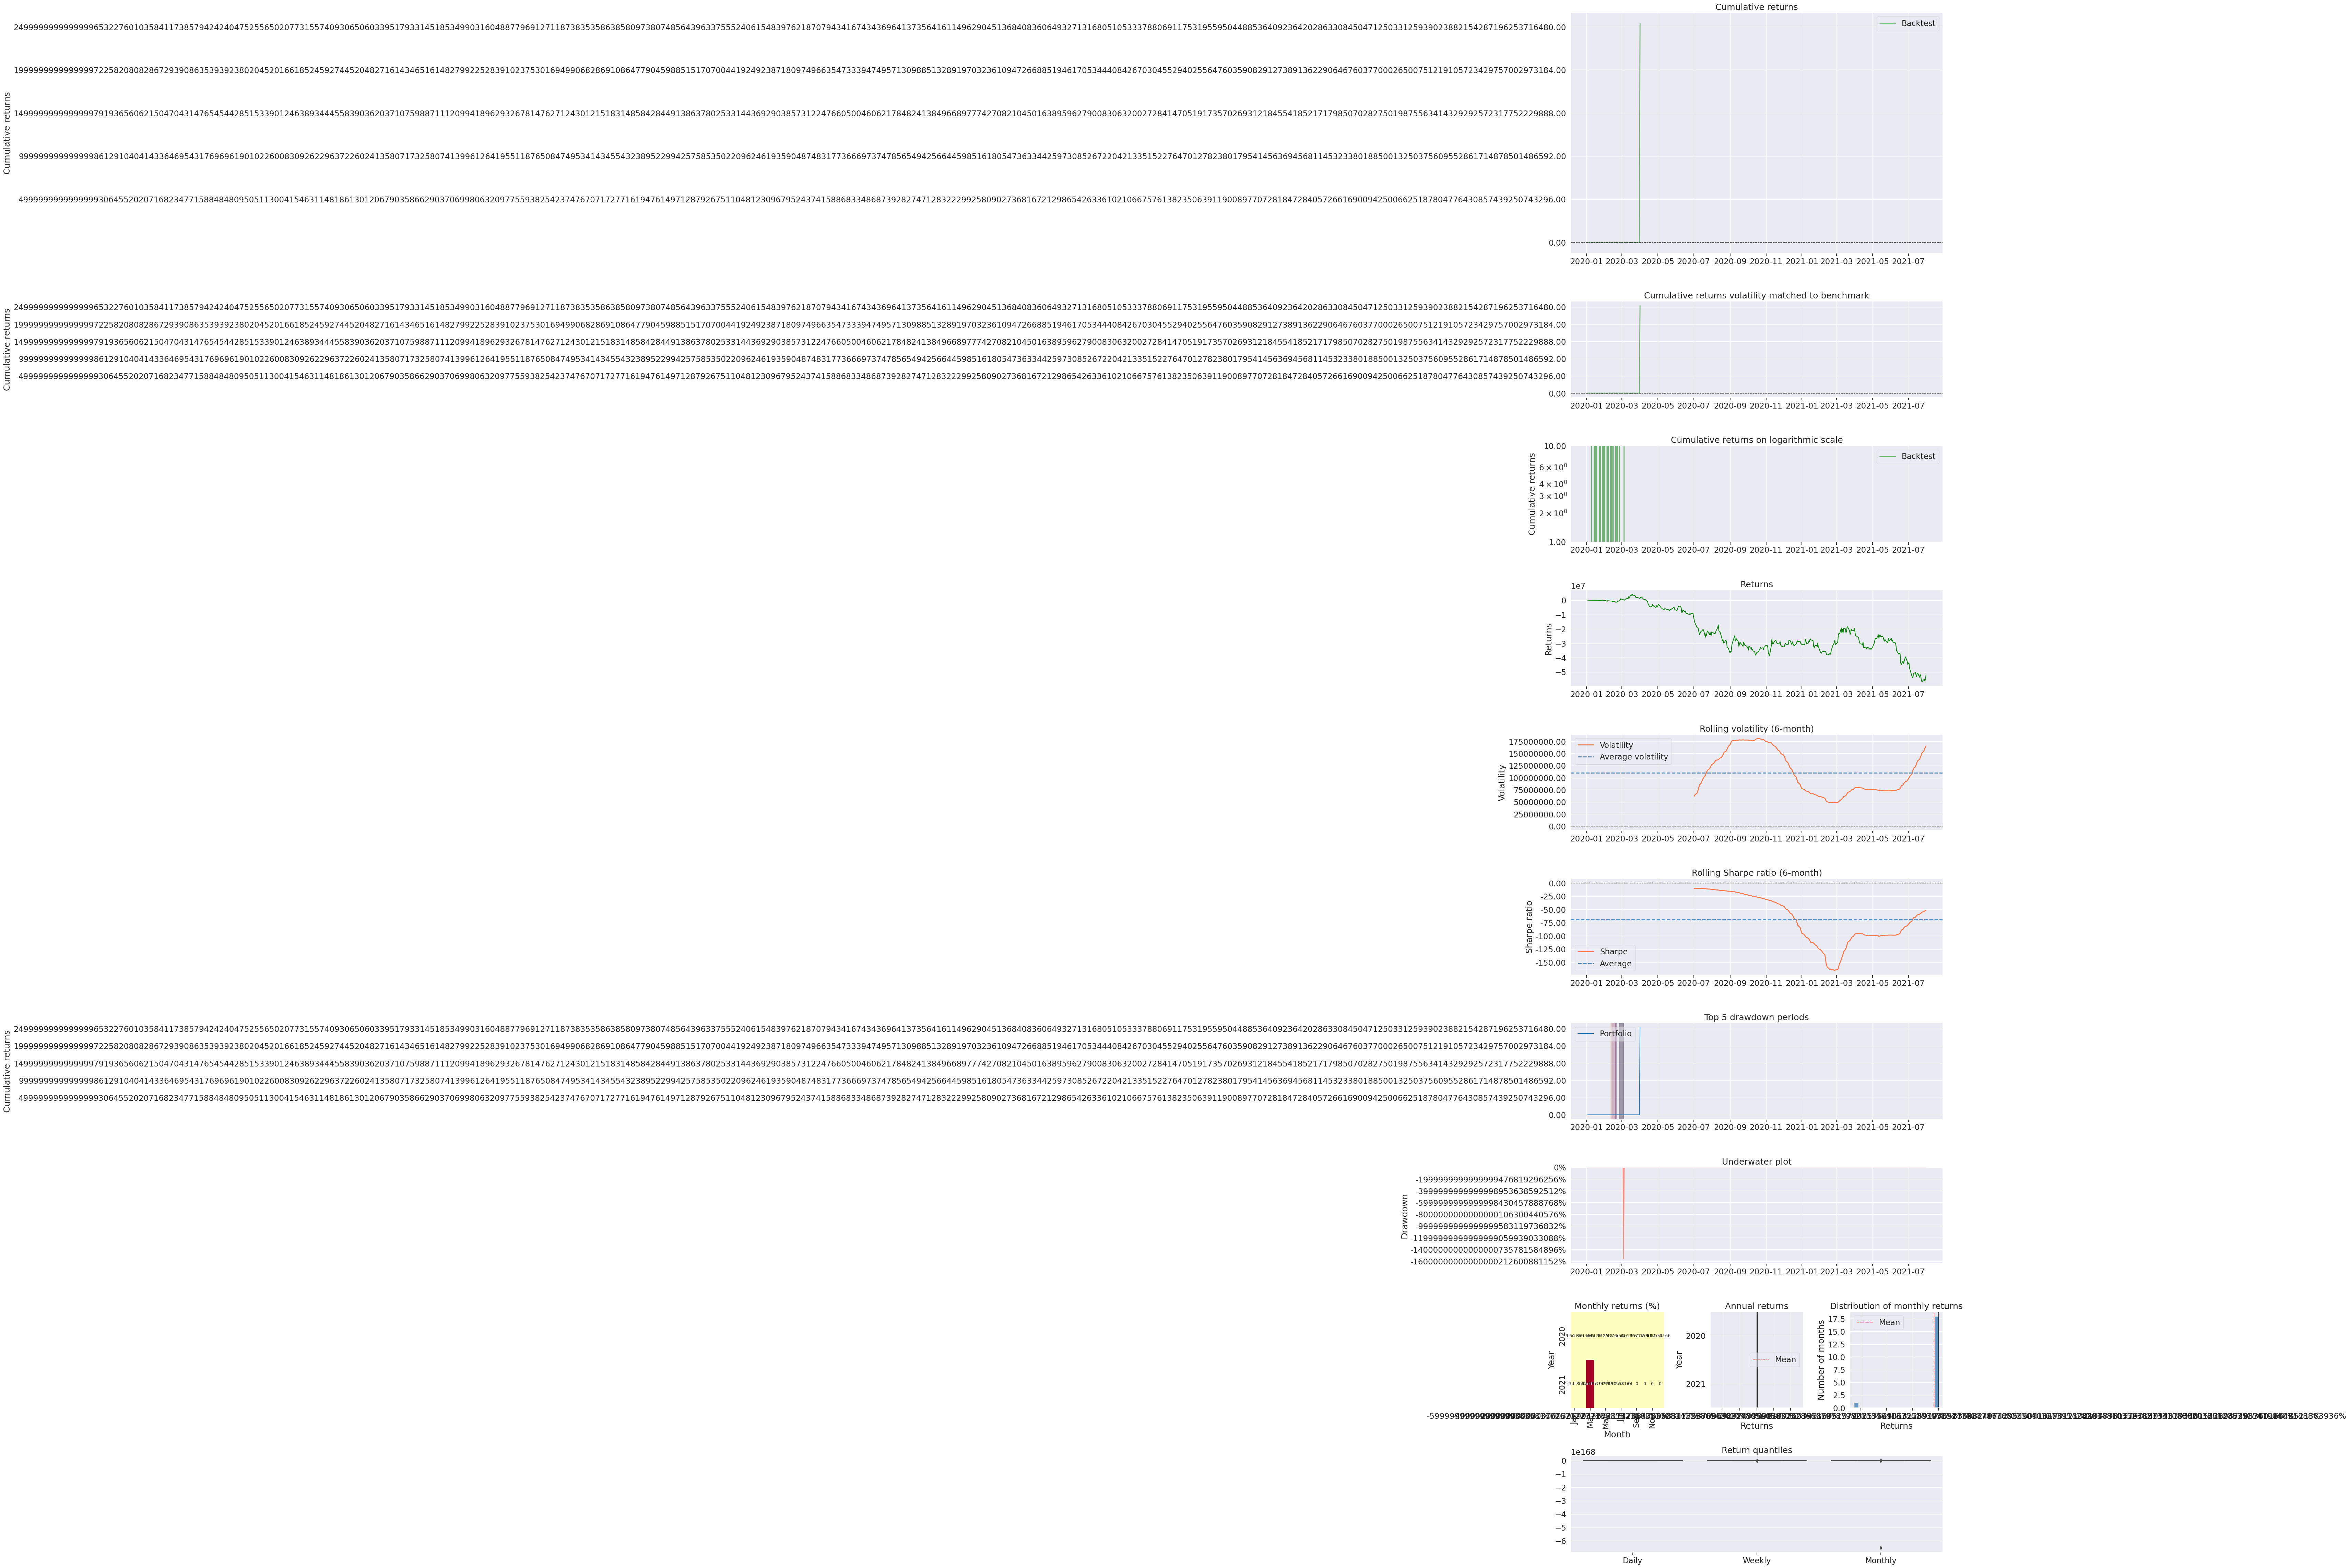

In [17]:
pf.create_returns_tear_sheet(returns=result.algorithm_period_return, benchmark_rets=None)

In [ ]:
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)

/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/data/data_portal.py:951: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


## Stop loss + Take profit

In [17]:
def initialize(context):
    context.i = 0
    set_benchmark(symbol(symb))
    sids = bundle_data.asset_finder.sids
    context.assets = bundle_data.asset_finder.retrieve_all(sids)
    context.bollinger_window = 20  # Bollinger Bands window
    context.bollinger_dev = 2  # Number of standard deviations for Bollinger Bands
    context.stop_loss_percent = 0.05  # Stop loss percentage
    context.take_profit_percent = 0.1  # Take profit percentage

def handle_data(context, data):
    for asset in context.assets:
        # Get historical price data
        prices = data.history(asset, 'close', context.bollinger_window + 1, frequency='1d')
        # Calculate Bollinger Bands
        sma = prices.mean()
        rolling_std = prices.std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        # Get the current price
        current_price = data.current(asset, 'close')

        open_orders = get_open_orders()

        # Check if the asset is still tradable
        if data.can_trade(asset):
            # Check existing position
            position = context.portfolio.positions[asset]

            # Generate signals based on Bollinger Bands
            if current_price > upper_band:
                # Short position with stop-loss and take-profit
                order_target_percent(asset, -0.5, stop_price=current_price * (1 + context.stop_loss_percent),
                                      limit_price=current_price * (1 - context.take_profit_percent))
            elif current_price < lower_band:
                # Long position with stop-loss and take-profit
                order_target_percent(asset, 0.5, stop_price=current_price * (1 - context.stop_loss_percent),
                                      limit_price=current_price * (1 + context.take_profit_percent))
            else:
                # Close position
                order_target_percent(asset, 0)

        # Record the values for later analysis
        record(price=current_price, upper=upper_band, lower=lower_band)
        record(
            AAPL=current_price,
            lower_band=lower_band, upper_band=upper_band,
            price_hist=prices
        )


In [ ]:
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)

/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/data/data_portal.py:951: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


In [ ]:
result["vols"] = result.starting_cash.pct_change().rolling(30).std()
def my_rolling_sharpe(ser):
    return np.sqrt(90) * (ser.mean()/ser.std())
result["sharpe_ratio"] = result['starting_cash'].pct_change().rolling(235).apply(my_rolling_sharpe)
fig, ax = plt.subplots(1, 3, figsize=(21,6))
result['sharpe_ratio'].plot(ax = ax[0], title='Sharpe Ratio')
result['vols'].plot(ax = ax[1], title='Volatility')
result['ending_cash'].plot(ax = ax[2], title='Cash')
plt.show()

# Ensemble(Bollinger Bands + MACD)

In [28]:
def initialize(context):
    context.i = 0
    set_benchmark(symbol(symb))
    sids = bundle_data.asset_finder.sids
    context.assets = bundle_data.asset_finder.retrieve_all(sids)
    context.bollinger_window = bollinger_window  # Bollinger Bands window
    context.bollinger_dev = bollinger_dev  # Number of standard deviations for Bollinger Bands
    context.stop_loss_percent = stop_loss_percent
    context.macd_short_window = 12
    context.macd_long_window = 26
    context.macd_signal_window = 9
    context.take_profit_percent=0.3

def exec_trade(data, positions):
    for asset, target_percent in positions.items():
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

def calculate_macd(prices, short_window, long_window, signal_window):
    exp12 = prices.ewm(span=short_window, adjust=False).mean()
    exp26 = prices.ewm(span=long_window, adjust=False).mean()
    macd = exp12 - exp26
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def handle_data(context, data):
    buy_signal = False
    sell_signal = False
    
    for asset in context.assets:
        # Get historical price data
        prices = data.history(asset, 'close', context.bollinger_window + context.macd_long_window + context.macd_signal_window + 1, frequency='1d')
        # Calculate Bollinger Bands
        sma = prices[-context.bollinger_window:].mean()
        rolling_std = prices[-context.bollinger_window:].std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        # Calculate MACD
        close_prices = prices[-context.macd_long_window:]
        macd, signal = calculate_macd(close_prices, context.macd_short_window, context.macd_long_window, context.macd_signal_window)

        # Get the current price
        current_price = data.current(asset, 'close')
    
        open_orders = get_open_orders()
        # Check if the asset is still tradable
        if data.can_trade(asset):
            cash = context.portfolio.cash
            # Generate signals based on Bollinger Bands and MACD
            if current_price > upper_band and macd.iloc[-1] > signal.iloc[-1] and macd.iloc[-2] < signal.iloc[-2]:
                limit_price = current_price * (1 - context.take_profit_percent)
                order_target(asset, -(cash // current_price), limit_price=limit_price)# Short position
                sell_signal = True
            elif current_price < lower_band and macd.iloc[-1] < signal.iloc[-1] and macd.iloc[-2] > signal.iloc[-2]:
                limit_price = current_price * (1 + context.take_profit_percent)
                order_target(asset, cash // current_price, limit_price=limit_price)# Long position
                buy_signal = True
            else:
                order_target_percent(asset, 0)  # Close position
        
        # Record the values for later analysis
        record(price=current_price, upper=upper_band, lower=lower_band, macd=macd.iloc[-1], signal=signal.iloc[-1])
        record(
            AAPL=current_price,
            lower_band=lower_band, upper_band=upper_band,
            sell_signal=sell_signal,
            buy_signal=buy_signal,
            price_hist=prices
        )


In [29]:
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)

/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/data/data_portal.py:951: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


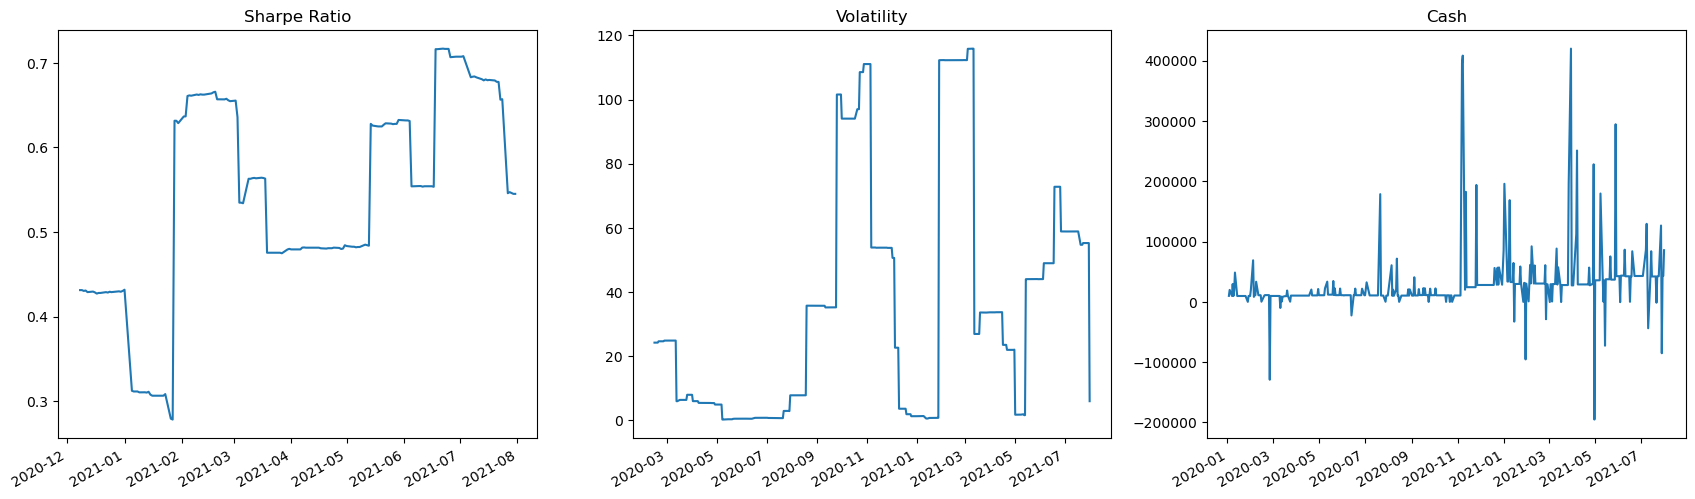

In [30]:
result["vols"] = result.starting_cash.pct_change().rolling(30).std()
def my_rolling_sharpe(ser):
    return np.sqrt(90) * (ser.mean()/ser.std())
result["sharpe_ratio"] = result['starting_cash'].pct_change().rolling(235).apply(my_rolling_sharpe)
fig, ax = plt.subplots(1, 3, figsize=(21,6))
result['sharpe_ratio'].plot(ax = ax[0], title='Sharpe Ratio')
result['vols'].plot(ax = ax[1], title='Volatility')
result['ending_cash'].plot(ax = ax[2], title='Cash')
plt.show()

/home/subrina/anaconda3/lib/python3.11/site-packages/pyfolio/plotting.py:666: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.6862170482934335e+64%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2021-07-30 20:00:00+0000', tz='UTC'))

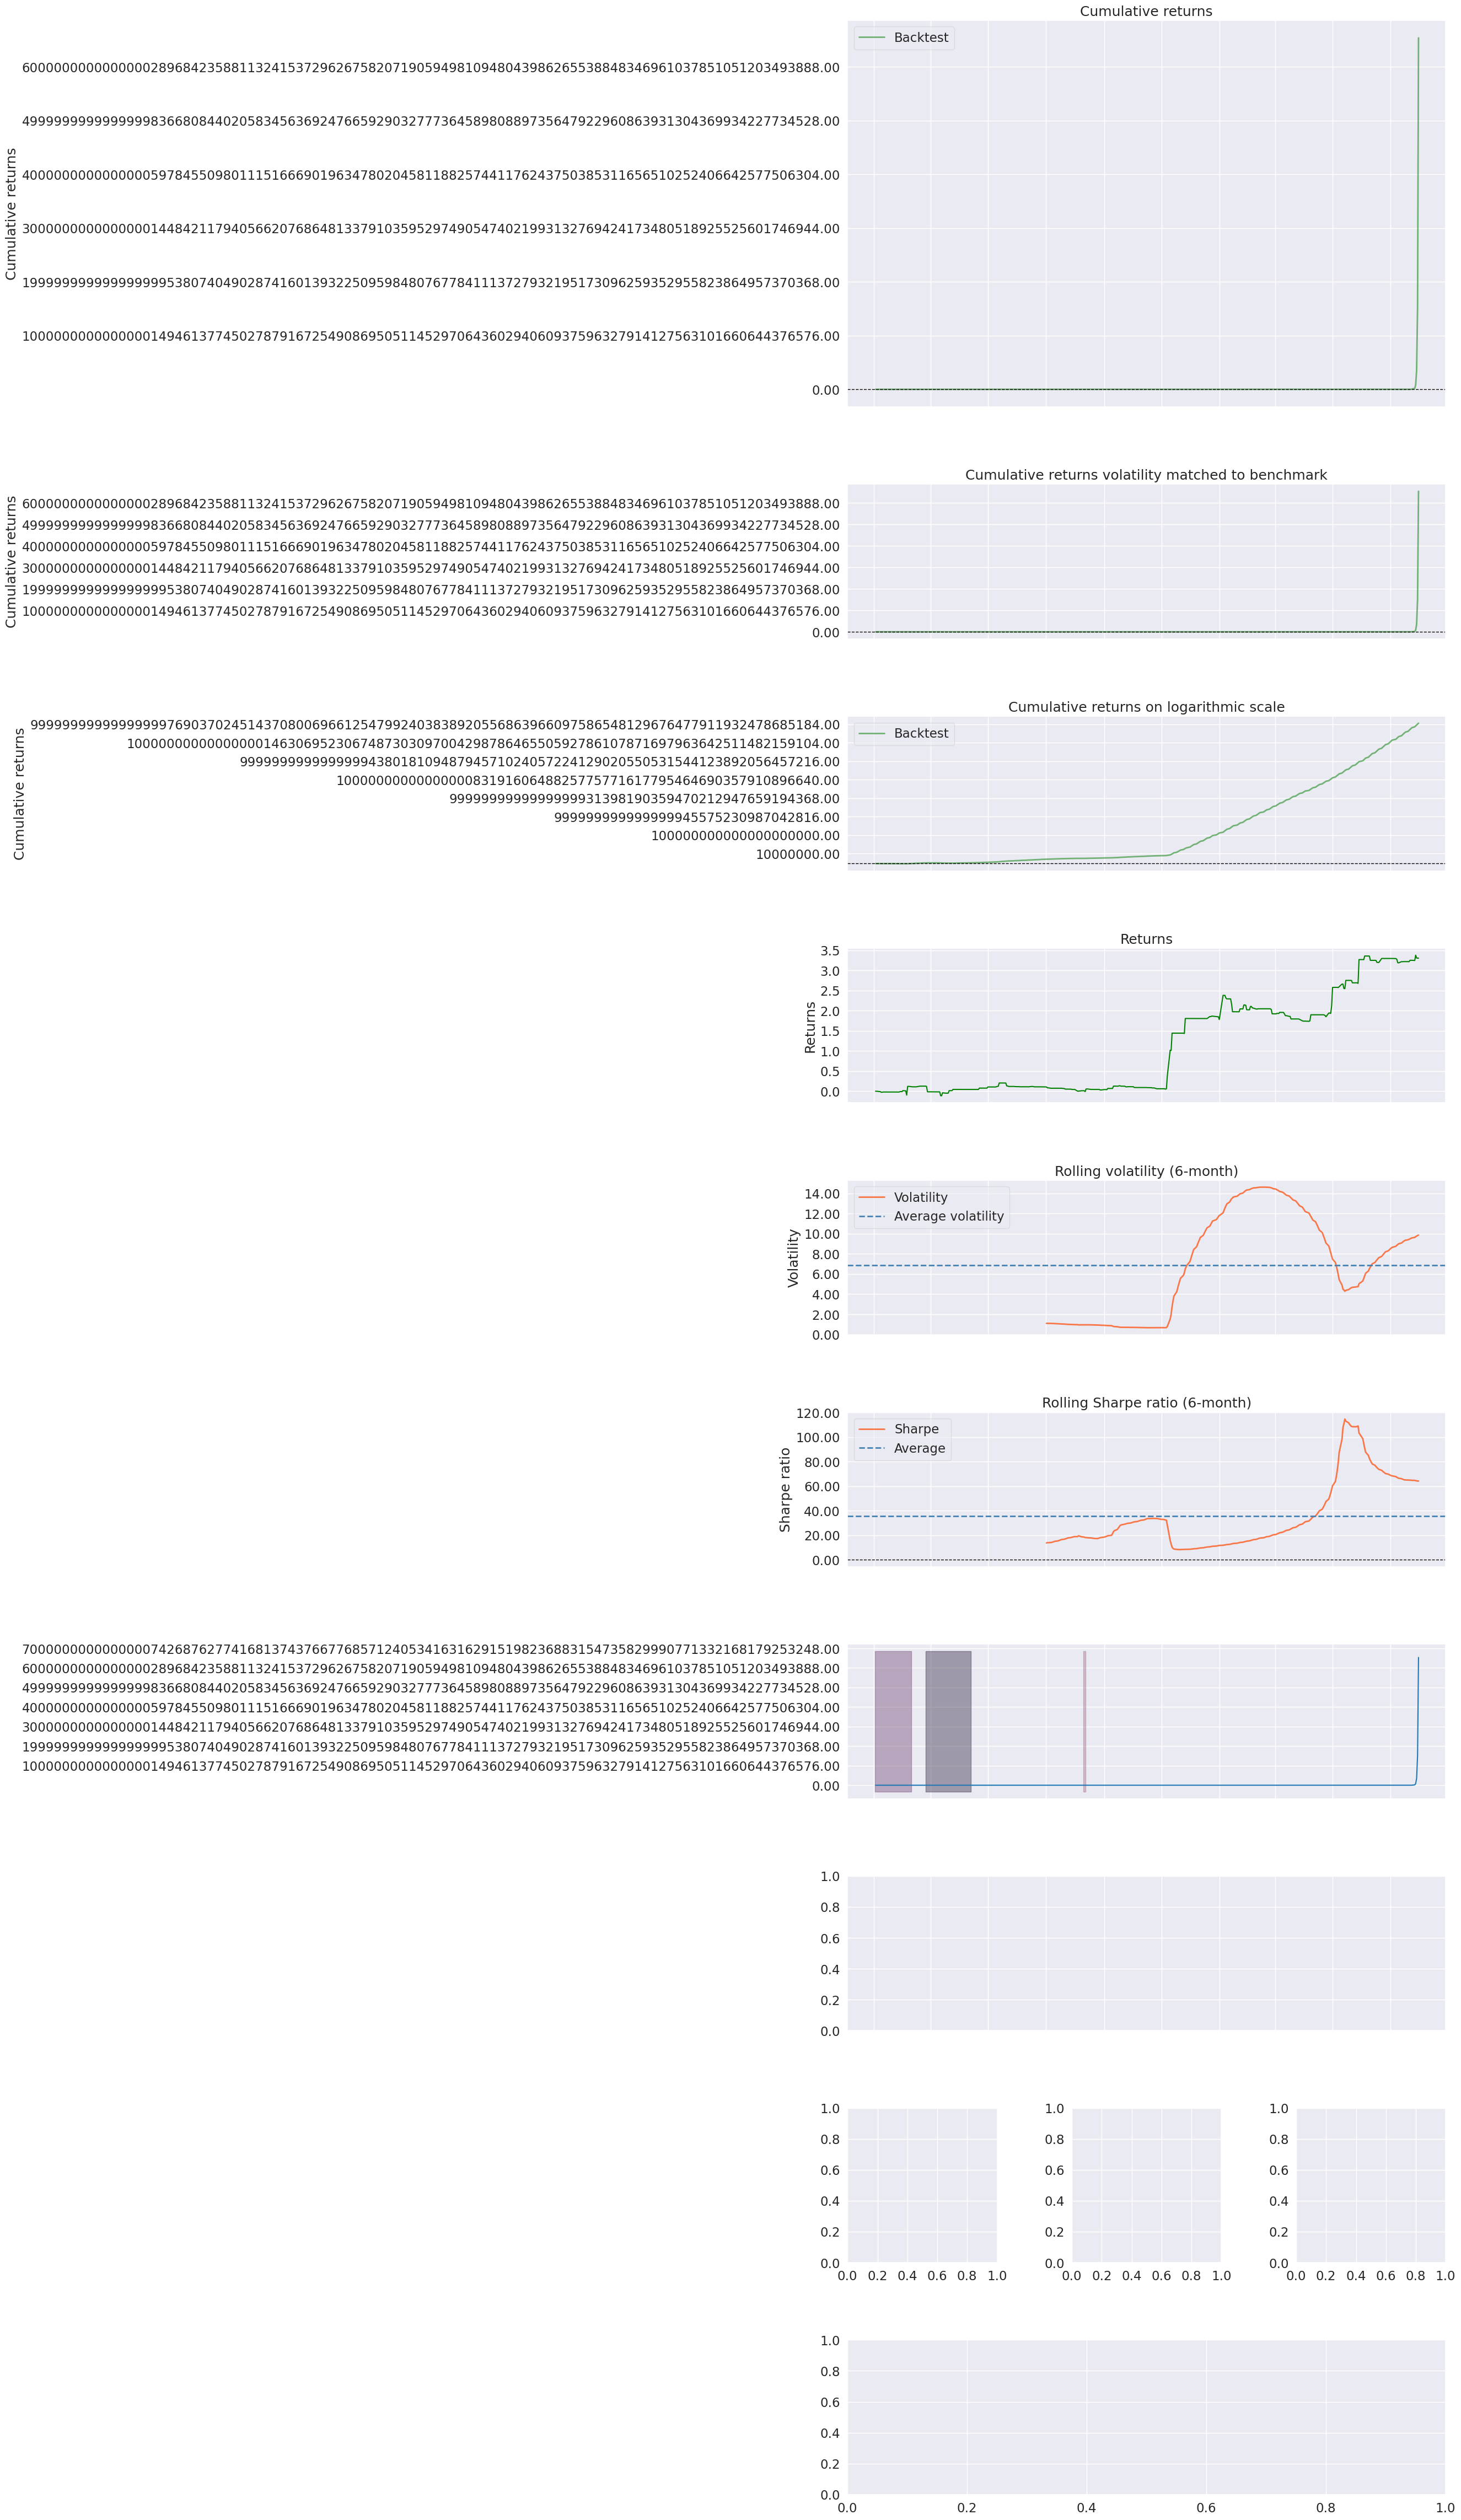

In [31]:
pf.create_returns_tear_sheet(returns=result.algorithm_period_return, benchmark_rets=None)

## Added Volume Filter

In [13]:
def handle_data(context, data):
    buy_signal = False
    sell_signal = False
    
    for asset in context.assets:
        # Get historical price data and volume
        prices = data.history(asset, 'close', context.bollinger_window + context.macd_long_window + context.macd_signal_window + 1, frequency='1d')
        volumes = data.history(asset, 'volume', context.bollinger_window + context.macd_long_window + context.macd_signal_window + 1, frequency='1d')

        # Calculate Bollinger Bands
        sma = prices[-context.bollinger_window:].mean()
        rolling_std = prices[-context.bollinger_window:].std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        # Calculate MACD
        close_prices = prices[-context.macd_long_window:]
        macd, signal = calculate_macd(close_prices, context.macd_short_window, context.macd_long_window, context.macd_signal_window)

        # Get the current price and volume
        current_price = data.current(asset, 'close')
        current_volume = data.current(asset, 'volume')

        # Calculate the average volume
        average_volume = volumes.mean()

        open_orders = get_open_orders()
        # Check if the asset is still tradable
        if data.can_trade(asset):
            cash = context.portfolio.cash
            # Generate signals based on Bollinger Bands, MACD, and volume
            if (
                current_price > upper_band
                and macd.iloc[-1] > signal.iloc[-1]
                and macd.iloc[-2] < signal.iloc[-2]
                and current_volume > average_volume
            ):
                order_target(asset, -(cash // current_price))  # Short position
                sell_signal = True
            elif (
                current_price < lower_band
                and macd.iloc[-1] < signal.iloc[-1]
                and macd.iloc[-2] > signal.iloc[-2]
                and current_volume > average_volume
            ):
                order_target(asset, cash // current_price)  # Long position
                buy_signal = True
            else:
                order_target(asset, 0)  # Close position
        
        # Record the values for later analysis
        record(price=current_price, upper=upper_band, lower=lower_band, macd=macd.iloc[-1], signal=signal.iloc[-1], volume=current_volume, average_volume=average_volume)
        record(
            AAPL=current_price,
            lower_band=lower_band, upper_band=upper_band,
            sell_signal=sell_signal,
            buy_signal=buy_signal,
            price_hist=prices,
            volume_hist=volumes
        )


In [14]:
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)

/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/data/data_portal.py:951: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


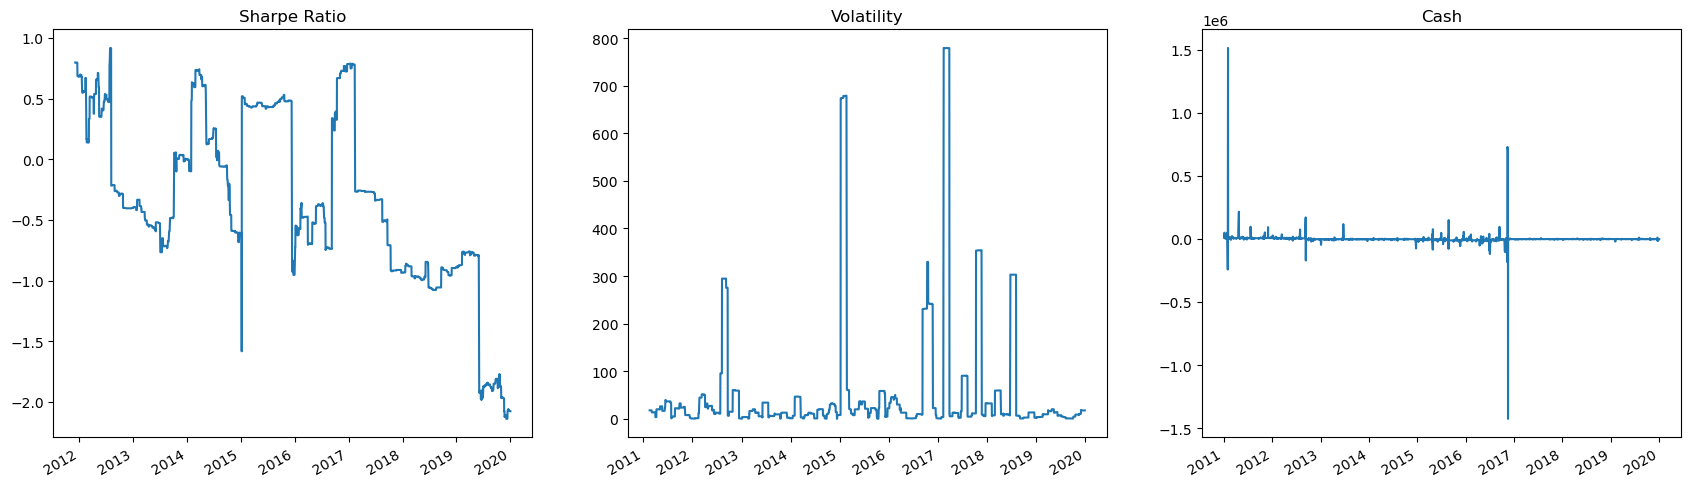

In [15]:
result["vols"] = result.starting_cash.pct_change().rolling(30).std()
def my_rolling_sharpe(ser):
    return np.sqrt(90) * (ser.mean()/ser.std())
result["sharpe_ratio"] = result['starting_cash'].pct_change().rolling(235).apply(my_rolling_sharpe)
fig, ax = plt.subplots(1, 3, figsize=(21,6))
result['sharpe_ratio'].plot(ax = ax[0], title='Sharpe Ratio')
result['vols'].plot(ax = ax[1], title='Volatility')
result['ending_cash'].plot(ax = ax[2], title='Cash')
plt.show()

/home/subrina/anaconda3/lib/python3.11/site-packages/empyrical/stats.py:1380: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()
/home/subrina/anaconda3/lib/python3.11/site-packages/pyfolio/plotting.py:666: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-100.0%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2019-12-31 21:00:00+0000', tz='UTC'))

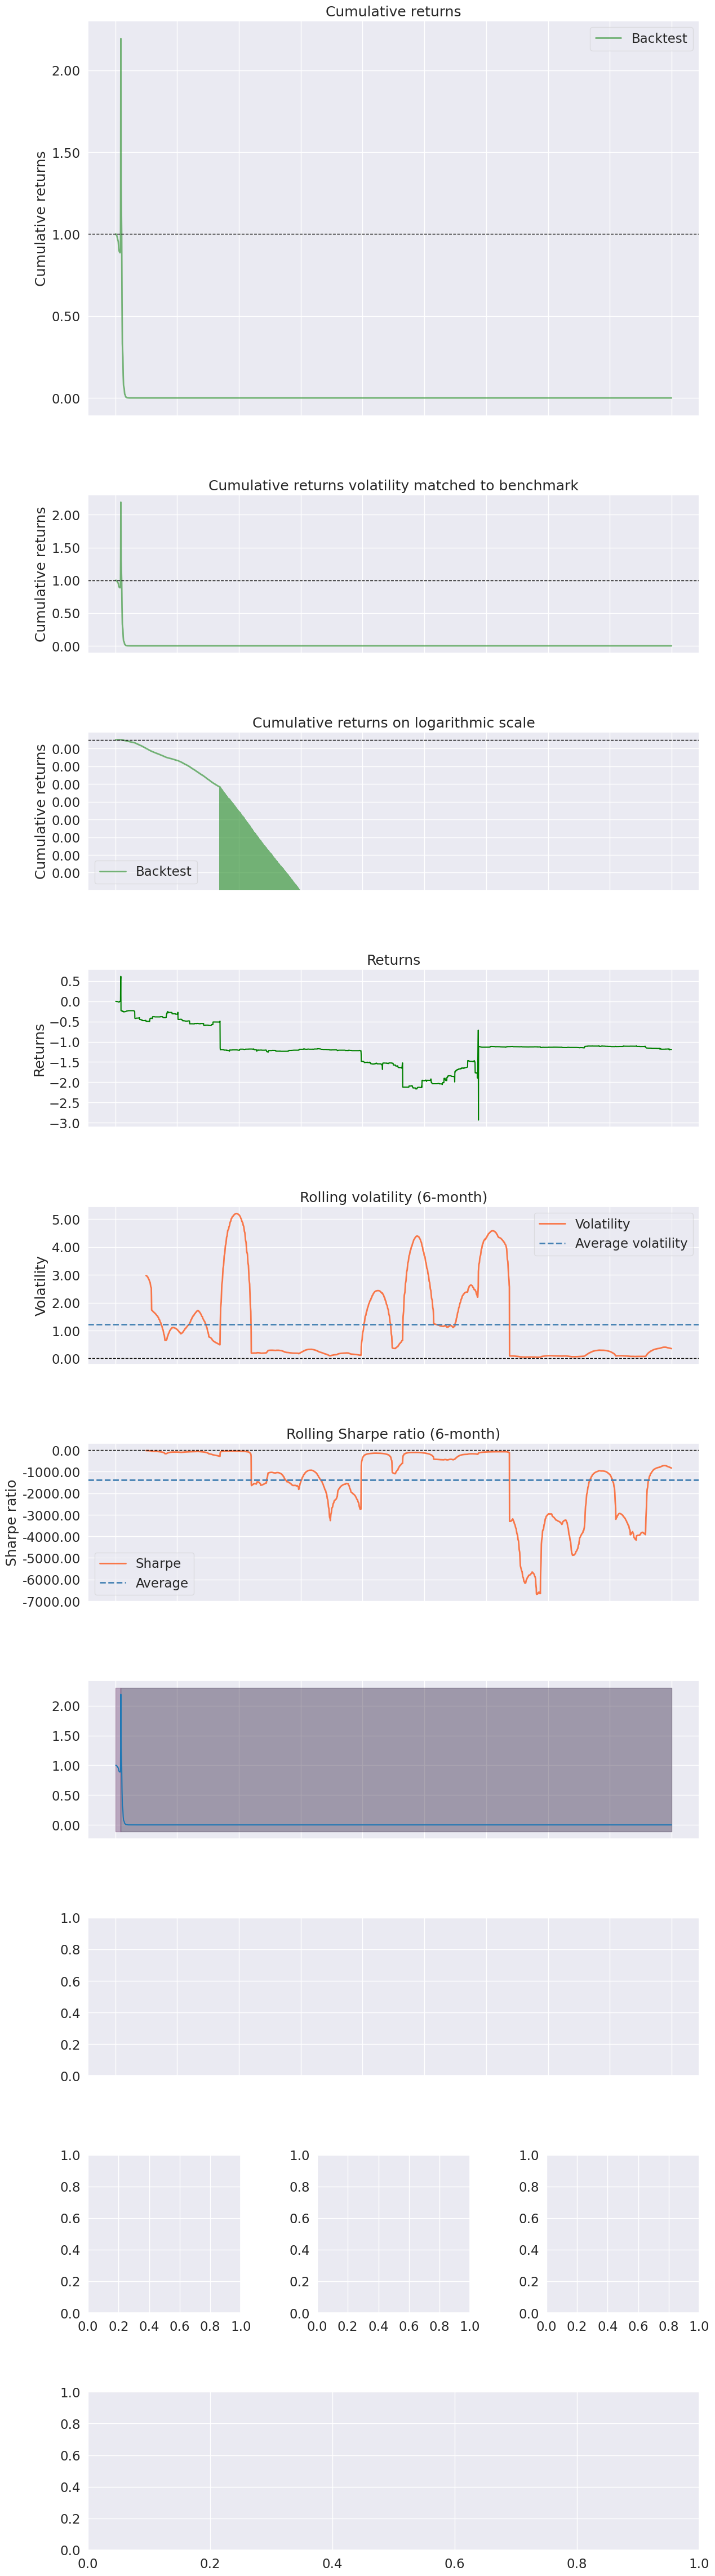

In [16]:
pf.create_returns_tear_sheet(returns=result.algorithm_period_return, benchmark_rets=None)

## Added Volatility Filter

In [12]:
def initialize(context):
    context.i = 0
    sids = bundle_data.asset_finder.sids
    context.assets = bundle_data.asset_finder.retrieve_all(sids)
    context.bollinger_window = 25  # Bollinger Bands window
    context.bollinger_dev = 1.5 # Number of standard deviations for Bollinger Bands
    context.macd_short_window = 8
    context.macd_long_window = 26
    context.macd_signal_window = 7
    context.max_volatility = 0.03
    
    
def calculate_macd(prices, short_window, long_window, signal_window):
    exp12 = prices.ewm(span=short_window, adjust=False).mean()
    exp26 = prices.ewm(span=long_window, adjust=False).mean()
    macd = exp12 - exp26
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

    
def handle_data(context, data):
    context.i += 1
    if context.i < max(context.bollinger_window,context.macd_long_window, context.macd_signal_window):
        return
    buy_signal = False
    sell_signal = False
    
    for asset in context.assets:
        # Get historical price data
        prices = data.history(asset, 'close', max(context.bollinger_window,context.macd_long_window, context.macd_signal_window) + 1, frequency='1d')
        
        # Calculate Bollinger Bands
        sma = prices[-context.bollinger_window:].mean()
        rolling_std = prices[-context.bollinger_window:].std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        # Calculate MACD
        close_prices = prices[-context.macd_long_window:]
        macd, signal = calculate_macd(close_prices, context.macd_short_window, context.macd_long_window, context.macd_signal_window)

        # Calculate historical returns for volatility calculation
        returns = prices.pct_change().dropna()

        # Calculate volatility as the standard deviation of returns
        volatility = returns.std()

        # Get the current price
        current_price = data.current(asset, 'close')
    
        open_orders = get_open_orders()
        # Check if the asset is still tradable and if volatility is below a certain threshold
        if data.can_trade(asset) and volatility < context.max_volatility:
            cash = context.portfolio.cash
            # Generate signals based on Bollinger Bands and MACD
            if current_price > upper_band and macd.iloc[-1] > signal.iloc[-1] and macd.iloc[-2] < signal.iloc[-2]:
                order_target(asset, -(cash // current_price))  # Short position
                sell_signal = True
            elif current_price < lower_band and macd.iloc[-1] < signal.iloc[-1] and macd.iloc[-2] > signal.iloc[-2]:
                order_target(asset, cash // current_price)  # Long position
                buy_signal = True
            else:
                order_target(asset, 0)  # Close position
        
        # Record the values for later analysis
        record(price=current_price, upper=upper_band, lower=lower_band, macd=macd.iloc[-1], signal=signal.iloc[-1], volatility=volatility)
        record(
            AAPL=current_price,
            lower_band=lower_band, upper_band=upper_band,
            sell_signal=sell_signal,
            buy_signal=buy_signal,
            price_hist=prices,
            volatility=volatility
        )


## Trail

In [ ]:
def initialize(context):
    context.i = 0
    sids = bundle_data.asset_finder.sids
    context.assets = bundle_data.asset_finder.retrieve_all(sids)
    context.bollinger_window = 25  # Bollinger Bands window
    context.bollinger_dev = 1.5 # Number of standard deviations for Bollinger Bands
    context.macd_short_window = 8
    context.macd_long_window = 26
    context.macd_signal_window = 7
    context.max_volatility = 0.03
    context.max_window=max(context.bollinger_window, context.macd_long_window)
    
    
def calculate_macd(prices, short_window, long_window, signal_window):
    exp12 = prices.ewm(span=short_window, adjust=False).mean()
    exp26 = prices.ewm(span=long_window, adjust=False).mean()
    macd = exp12 - exp26
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

    
def handle_data(context, data):
    context.i += 1
    if context.i < context.max_window:
        return
    buy_signals = {}
    sell_signals = {}

    # Get the closing price data for all assets for the past max_window + 1 days.
    prices = data.history(context.assets, "close", context.max_window + 1, frequency="1d")

    # Pre-calculate some common values to avoid redundant calculations.
    # Rolling averages for the past 25 days for each asset.
    rolling_means = prices.rolling(window=context.max_window).mean()
    # Rolling standard deviations for the past 25 days for each asset.
    rolling_stds = prices.rolling(window=context.max_window).std()
    
    for i, asset in enumerate(context.assets):
    # Get the current price of the asset.
    current_price = prices.iloc[-1, i]

    # Calculate the upper and lower Bollinger Bands based on the rolling mean and standard deviation.
    upper_band = rolling_means.iloc[-1, i] + (context.bollinger_dev * rolling_stds.iloc[-1, i])
    lower_band = rolling_means.iloc[-1, i] - (context.bollinger_dev * rolling_stds.iloc[-1, i])

    # Extract the last 26 closing prices for MACD calculation.
    macd_prices = prices.iloc[- context.macd_long_window:, i]

    # Calculate the Exponential Moving Averages (EMAs) for MACD.
    ewma_fast = macd_prices.ewm(span=context.macd_short_window, min_periods=context.macd_short_window, adjust=False).mean()
    ewma_slow = macd_prices.ewm(span=context.macd_long_window, min_periods=context.macd_long_window, adjust=False).mean()

    # Calculate the MACD and its signal line.
    macd = ewma_fast - ewma_slow
    signal = macd.ewm(span=context.macd_signal_window , min_periods=context.macd_signal_window , adjust=False).mean()

    # Calculate annualized standard deviation for volatility (more accurate than standard deviation).
    annualized_std = prices.iloc[1:].pct_change().std() * np.sqrt(252)
    
    for asset in context.assets:
        # Get historical price data
        prices = data.history(asset, 'close', context.max_window + 1, frequency='1d')
        
        # Calculate Bollinger Bands
        sma = prices[-context.bollinger_window:].mean()
        rolling_std = prices[-context.bollinger_window:].std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        # Calculate MACD
        close_prices = prices[-context.macd_long_window:]
        macd, signal = calculate_macd(close_prices, context.macd_short_window, context.macd_long_window, context.macd_signal_window)

        # Calculate historical returns for volatility calculation
        returns = prices.pct_change().dropna()

        # Calculate volatility as the standard deviation of returns
        volatility = returns.std()

        # Get the current price
        current_price = data.current(asset, 'close')
    
        open_orders = get_open_orders()
        # Check if the asset is still tradable and if volatility is below a certain threshold
        if data.can_trade(asset) and volatility < context.max_volatility:
            cash = context.portfolio.cash
            # Generate signals based on Bollinger Bands and MACD
            if current_price > upper_band and macd.iloc[-1] > signal.iloc[-1] and macd.iloc[-2] < signal.iloc[-2]:
                order_target(asset, -(cash // current_price))  # Short position
                sell_signal = True
            elif current_price < lower_band and macd.iloc[-1] < signal.iloc[-1] and macd.iloc[-2] > signal.iloc[-2]:
                order_target(asset, cash // current_price)  # Long position
                buy_signal = True
            else:
                order_target(asset, 0)  # Close position
        
        # Record the values for later analysis
        record(price=current_price, upper=upper_band, lower=lower_band, macd=macd.iloc[-1], signal=signal.iloc[-1], volatility=volatility)
        record(
            AAPL=current_price,
            lower_band=lower_band, upper_band=upper_band,
            sell_signal=sell_signal,
            buy_signal=buy_signal,
            price_hist=prices,
            volatility=volatility
        )


In [ ]:
# This function is called once at the beginning.
def initialize(context):
    # Track the number of times handle_data has been called (not used in this example).
    context.i = 0
    # Get a list of all available assets.
    sids = bundle_data.asset_finder.sids
    # Store all assets as a list in the context object.
    context.assets = bundle_data.asset_finder.retrieve_all(sids)
    # Define the longest window needed for any indicator (25 for Bollinger Bands, 26 for MACD).
    context.max_window = max(25, 26)

# This function is called at every new data point (usually daily).
def handle_data(context, data):
    # Dictionaries to store buy and sell signals for each asset.
    buy_signals = {}
    sell_signals = {}

    # Get the closing price data for all assets for the past max_window + 1 days.
    prices = data.history(context.assets, "close", context.max_window + 1, frequency="1d")

    # Pre-calculate some common values to avoid redundant calculations.
    # Rolling averages for the past 25 days for each asset.
    rolling_means = prices.rolling(window=25).mean()
    # Rolling standard deviations for the past 25 days for each asset.
    rolling_stds = prices.rolling(window=25).std()

    # Loop through each asset in the list.
    for i, asset in enumerate(context.assets):
        # Get the current price of the asset.
        current_price = prices.iloc[-1, i]

        # Calculate the upper and lower Bollinger Bands based on the rolling mean and standard deviation.
        upper_band = rolling_means.iloc[-1, i] + 1.5 * rolling_stds.iloc[-1, i]
        lower_band = rolling_means.iloc[-1, i] - 1.5 * rolling_stds.iloc[-1, i]

        # Extract the last 26 closing prices for MACD calculation.
        macd_prices = prices.iloc[-26:, i]

        # Calculate the Exponential Moving Averages (EMAs) for MACD.
        ewma_fast = macd_prices.ewm(span=8, min_periods=8, adjust=False).mean()
        ewma_slow = macd_prices.ewm(span=26, min_periods=26, adjust=False).mean()

        # Calculate the MACD and its signal line.
        macd = ewma_fast - ewma_slow
        signal = macd.ewm(span=7, min_periods=7, adjust=False).mean()

        # Calculate annualized standard deviation for volatility (more accurate than standard deviation).
        annualized_std = prices.iloc[1:].pct_change().std() * np.sqrt(252)

        # Check if the asset is tradable and has low enough volatility.
        if data.can_trade(asset) and annualized_std < context.max_volatility:
            # Get the available cash in the portfolio.
            cash = context.portfolio.cash

            # Buy signal: price above upper band, MACD crossing above its signal line.
            if current_price > upper_band and macd.iloc[-1] > signal.iloc[-1] and macd.iloc[-2] < signal.iloc[-2]:
                buy_signals[asset] = -(cash // current_price)  # Short position (negative quantity).

            # Sell signal: price below lower band, MACD crossing below its signal line.
            elif current_price < lower_band and macd.iloc[-1] < signal.iloc[-1] and macd.iloc[-2] > signal.iloc[-2]:
                sell_signals[asset] = cash // current_price  # Long position (positive quantity).

            # Close any existing position if no buy or sell signal is triggered.
            else:
                sell_signals[asset] = 0

    # Place orders for all assets with buy or sell signals (in one batch for increased efficiency).
    order_target_percent(buy_signals)
    order_target_percent(sell_signals)

    # Record some data for analysis and visualization.
    record(


In [ ]:
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)

/tmp/ipykernel_5235/2070843553.py:39: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()
/home/subrina/anaconda3/lib/python3.11/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


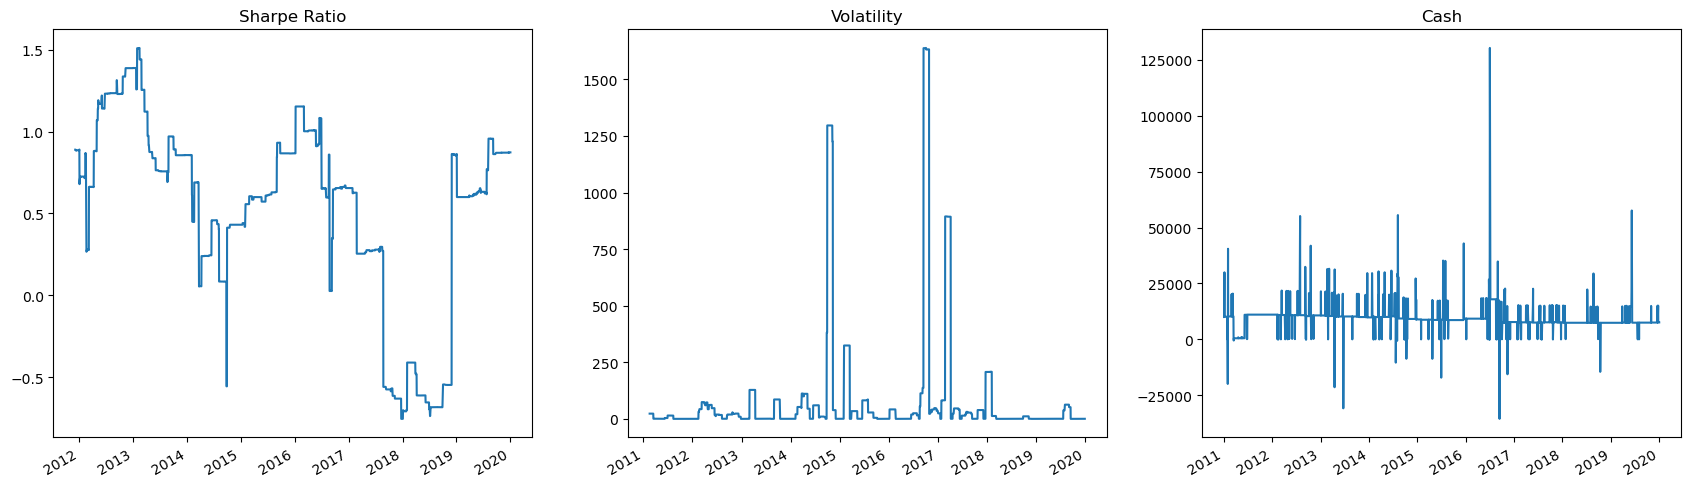

In [11]:
result["vols"] = result.starting_cash.pct_change().rolling(30).std()
def my_rolling_sharpe(ser):
    return np.sqrt(90) * (ser.mean()/ser.std())
result["sharpe_ratio"] = result['starting_cash'].pct_change().rolling(235).apply(my_rolling_sharpe)
fig, ax = plt.subplots(1, 3, figsize=(21,6))
result['sharpe_ratio'].plot(ax = ax[0], title='Sharpe Ratio')
result['vols'].plot(ax = ax[1], title='Volatility')
result['ending_cash'].plot(ax = ax[2], title='Cash')
plt.show()

/home/subrina/anaconda3/lib/python3.11/site-packages/pyfolio/plotting.py:666: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-100.0%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2019-12-31 21:00:00+0000', tz='UTC'))

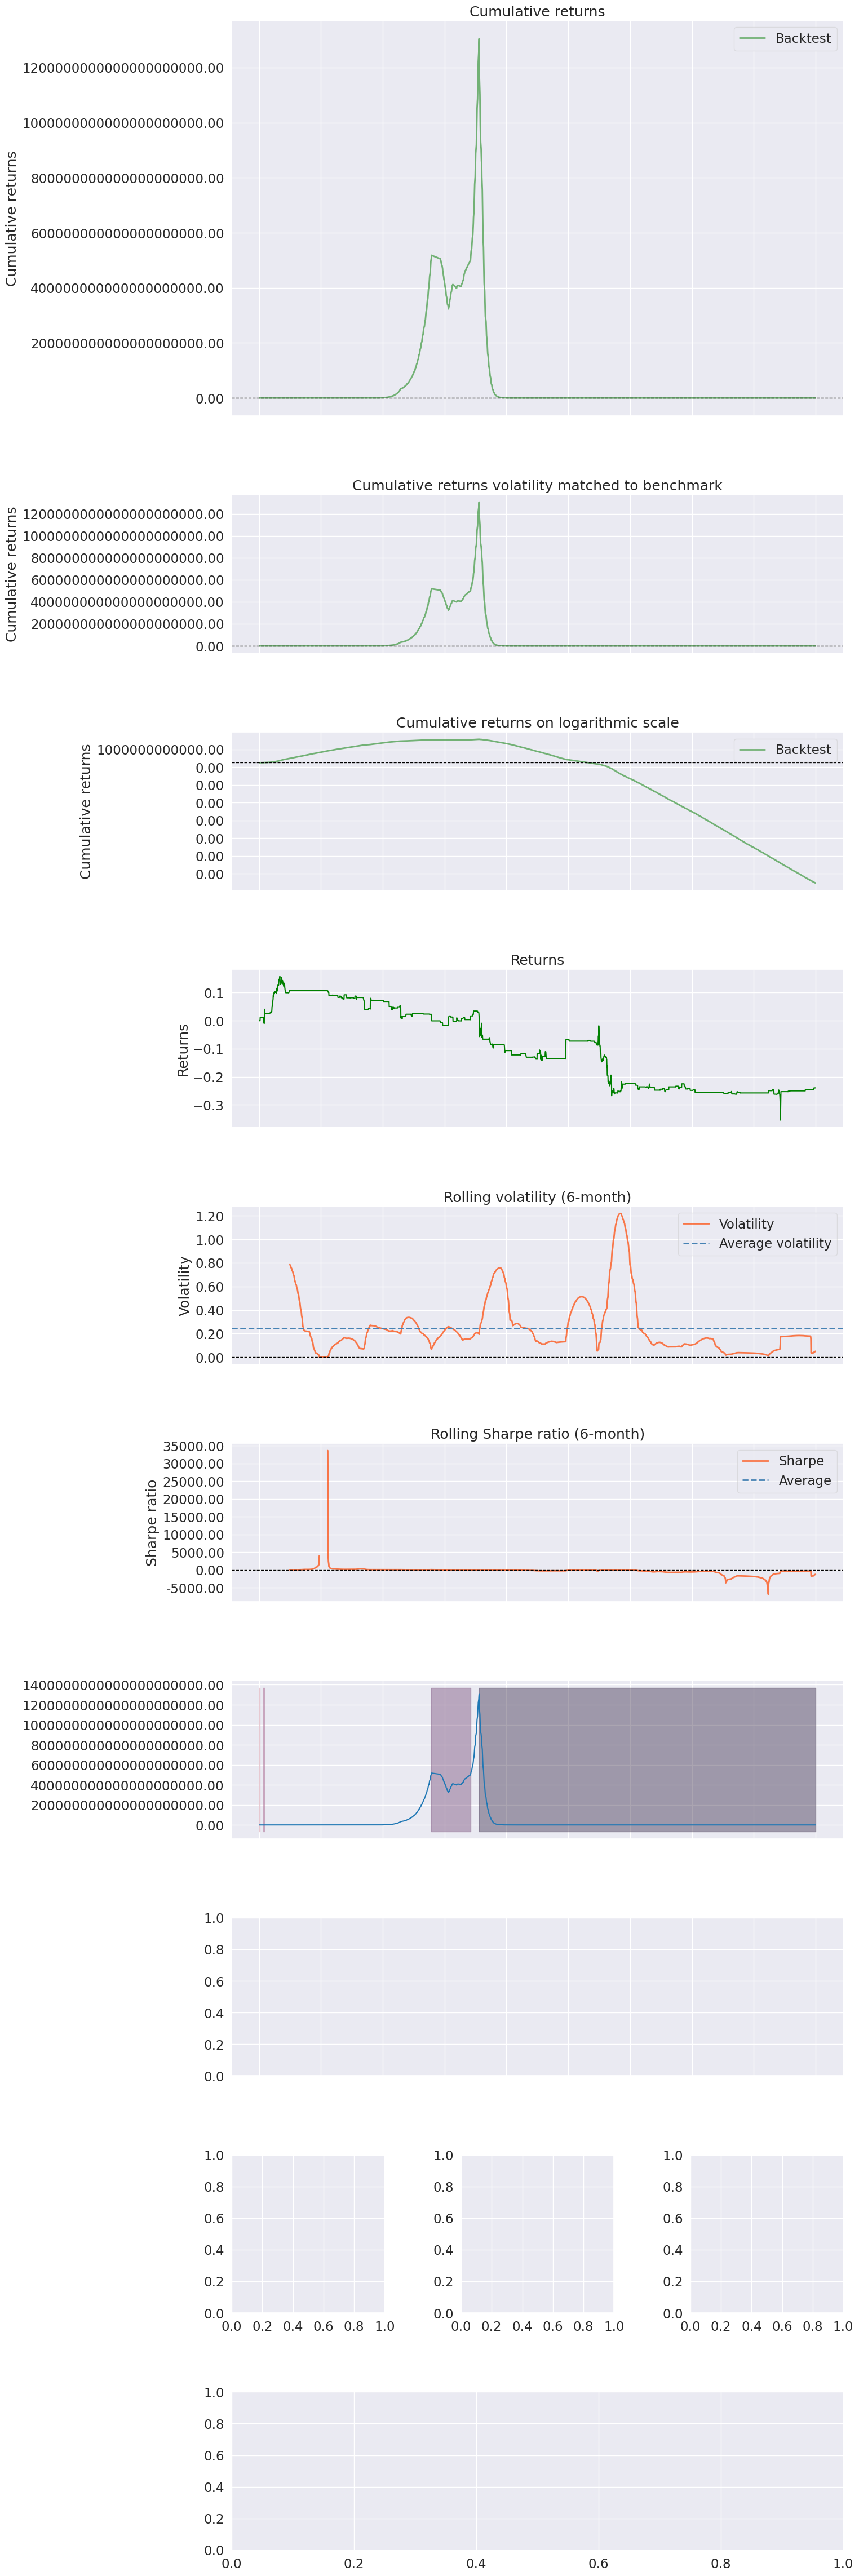

In [12]:
pf.create_returns_tear_sheet(returns=result.algorithm_period_return, benchmark_rets=None)